In [2]:
!pip install segmentation-models

In [3]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

In [4]:
import numpy as np 
import pandas as pd 
import tifffile as tiff
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.layers import Input, Conv2DTranspose,concatenate, Conv2D,Dropout,MaxPooling2D
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
import imageio.v2 as imageio
from keras.callbacks import ModelCheckpoint ,ReduceLROnPlateau,EarlyStopping
import segmentation_models as sm
import keras

Segmentation Models: using `tf.keras` framework.


In [5]:
path = ''
image_path = os.path.join(path, '/kaggle/input/water-segmentation/Water_seg/images/')
label_path = os.path.join(path, '/kaggle/input/water-segmentation/Water_seg/New labels/')
image_list_orig = os.listdir(image_path)
label_list_orig = os.listdir(label_path)

image_list = [image_path+i for i in image_list_orig]
label_list = [label_path+i for i in label_list_orig]

In [6]:
# Ensure both lists are sorted identically before splitting
image_list.sort()
label_list.sort()

In [7]:
print(image_list[:3])
print(label_list[:3])


['/kaggle/input/water-segmentation/Water_seg/images/0.tif', '/kaggle/input/water-segmentation/Water_seg/images/1.tif', '/kaggle/input/water-segmentation/Water_seg/images/10.tif']
['/kaggle/input/water-segmentation/Water_seg/New labels/0.png', '/kaggle/input/water-segmentation/Water_seg/New labels/1.png', '/kaggle/input/water-segmentation/Water_seg/New labels/10.png']


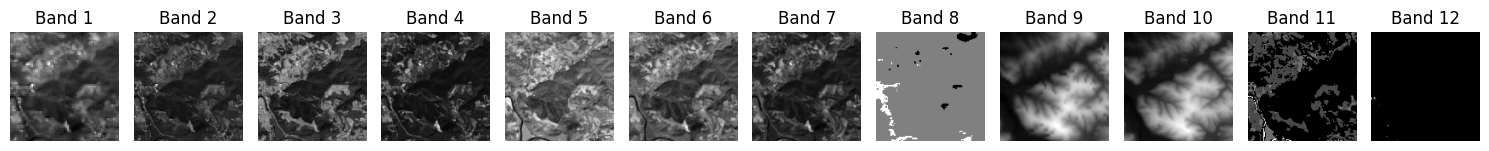

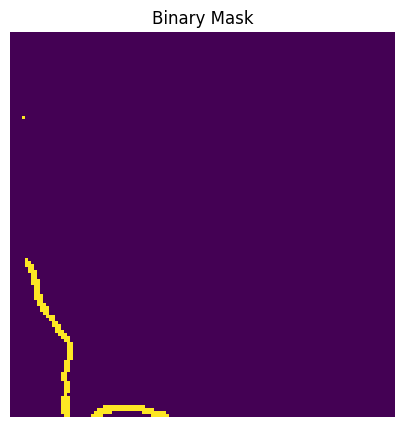

In [8]:
N = 1
img = imageio.imread(image_list[N])
mask = imageio.imread(label_list[N])
num_bands = img.shape[-1]
fig, axes = plt.subplots(1, num_bands, figsize=(15, 5))
for i in range(num_bands):
    axes[i].imshow(img[:, :,i],cmap='gray')
    axes[i].set_title(f'Band {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


plt.figure(figsize=(5, 5))
plt.imshow(mask)  
plt.title('Binary Mask')
plt.axis('off')
plt.show()

In [9]:


# Split into training and remaining sets
train_images, remaining_images, train_labels, remaining_labels = train_test_split(
    image_list, label_list, test_size=0.2, random_state=42  # 20% of the data will be split for validation and testing
)

# Further split remaining data into validation and testing sets
val_images, test_images, val_labels, test_labels = train_test_split(
    remaining_images, remaining_labels, test_size=0.50, random_state=42  # Split remaining data equally into validation and testing
)


print(f"Training set size: {len(train_images)} images, {len(train_labels)} labels")
print(f"Validation set size: {len(val_images)} images, {len(val_labels)} labels")
print(f"Testing set size: {len(test_images)} images, {len(test_labels)} labels")

Training set size: 244 images, 244 labels
Validation set size: 31 images, 31 labels
Testing set size: 31 images, 31 labels


In [10]:


# Data augmentation for training set
train_data_gen_args = dict(rescale=1./255,
                           rotation_range=10,
#                            width_shift_range=0.1,
#                            height_shift_range=0.1,
#                            shear_range=0.1,
#                            zoom_range=0.1,
#                            .channel_shift_range = 0.2,
#                            horizontal_flip=True,
#                            vertical_flip = True,
#                            fill_mode='nearest'
                          )

# Simple rescaling for validation and test sets
val_test_data_gen_args = dict(rescale=1./255)

# ImageDataGenerators
train_image_datagen = ImageDataGenerator(**train_data_gen_args)
train_mask_datagen = ImageDataGenerator(**train_data_gen_args)

val_image_datagen = ImageDataGenerator(**val_test_data_gen_args)
val_mask_datagen = ImageDataGenerator(**val_test_data_gen_args)

test_image_datagen = ImageDataGenerator(**val_test_data_gen_args)
test_mask_datagen = ImageDataGenerator(**val_test_data_gen_args)

def load_image(img_path, label_path, target_size):
    """
    Function to load and preprocess images and their corresponding masks.
    
    Parameters:
    - img_path: str, path to the image file
    - label_path: str, path to the label file
    - target_size: tuple, the desired size of the output images and masks
    
    Returns:
    - img: preprocessed image with selected channels
    - mask: preprocessed mask
    """
    # Load the image (assuming it has 12 channels)
    img = imageio.imread(img_path)
    
    # Select 3 channels from the image 
    img = img[:, :, [2, 5, 7]]  

    # Load the mask
    mask = imageio.imread(label_path)
    
    # If the mask is 2D, add a channel dimension
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, axis=-1)
    
    # Resize the image and mask to target_size
    img = tf.image.resize(img, target_size)
    mask = tf.image.resize(mask, target_size)
    
    # Ensure mask is binary (0 or 1)
    mask = tf.cast(mask > 0.5, tf.float32)
    
    return img, mask


def apply_random_transform(image, mask, seed=None):
    """
    Apply the same random transformation to both image and mask.
    
    Parameters:
    - image: TensorFlow tensor or Numpy array, the image to transform
    - mask: TensorFlow tensor or Numpy array, the mask to transform
    - seed: int, seed for random number generator
    
    Returns:
    - Transformed image and mask
    """
    if seed is not None:
        tf.random.set_seed(seed)
    
    # Use ImageDataGenerator for transformation
    image = image.numpy()  # Convert the image tensor to a numpy array
    mask = mask.numpy()  # Convert the mask tensor to a numpy array
    
    image = train_image_datagen.random_transform(image, seed=seed)
    mask = train_mask_datagen.random_transform(mask, seed=seed)
    
    return image, mask

def train_generator(image_list, label_list, batch_size, target_size, image_datagen, mask_datagen):
    """
    A generator to yield batches of images and masks.
    
    Parameters:
    - image_list: list, list of image file paths
    - label_list: list, list of label file paths
    - batch_size: int, number of images per batch
    - target_size: tuple, desired output size of the images and masks
    - image_datagen: ImageDataGenerator instance for augmenting the images
    - mask_datagen: ImageDataGenerator instance for augmenting the masks
    
    Yields:
    - Tuple of (images, masks)
    """
    while True:
        X_batch = []
        y_batch = []

        for i in range(batch_size):
            # Choose a random index
            idx = np.random.randint(0, len(image_list)-1)
            
            # Get the paths for the image and label
            img_path = image_list[idx]
            label_path = label_list[idx]
            
            # Load and preprocess the image and mask
            img, mask = load_image(img_path, label_path, target_size)
            
            # Apply random transformations
            seed = np.random.randint(1e6)
            img, mask = apply_random_transform(img, mask, seed=seed)
            
            X_batch.append(img)
            y_batch.append(mask)
        
        # Convert lists to numpy arrays
        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)
        
        yield X_batch, y_batch
        

In [11]:
# Parameters
img_height = 128
img_width = 128
num_channels = 3
batch_size = 8
image_size = (128, 128)  # Desired size for images
# Train, validation, and test generators
train_gen = train_generator(train_images, train_labels, batch_size, image_size, train_image_datagen, train_mask_datagen)
val_gen = train_generator(val_images, val_labels, batch_size, image_size, val_image_datagen, val_mask_datagen)
test_gen = train_generator(test_images, test_labels, batch_size, image_size, test_image_datagen, test_mask_datagen)

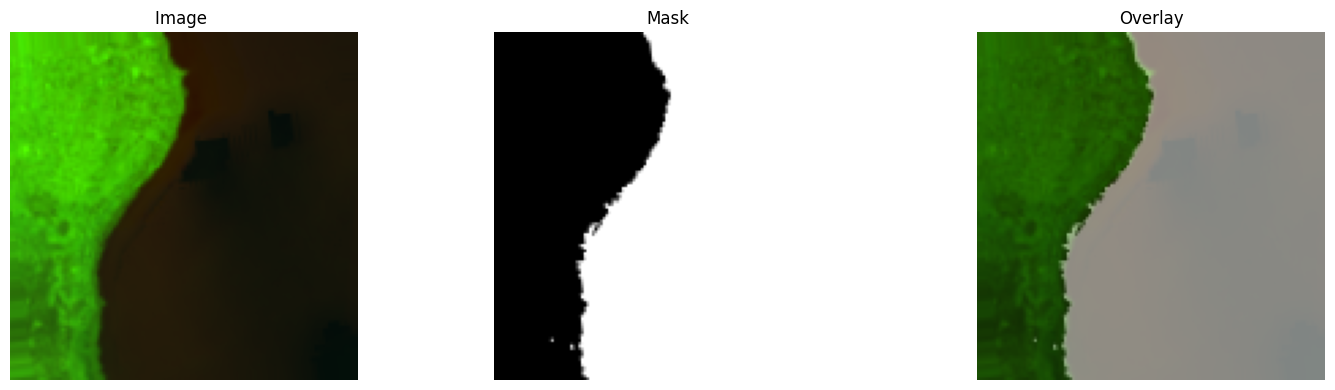

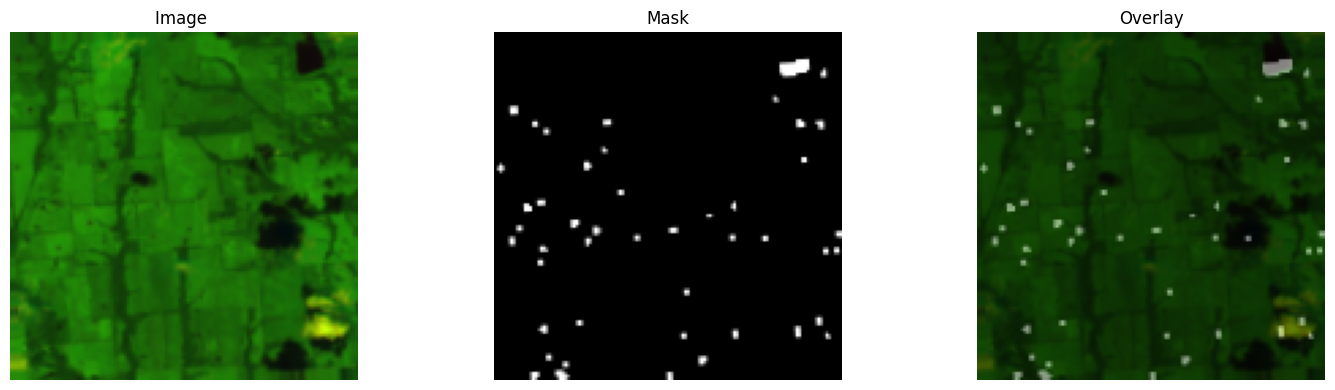

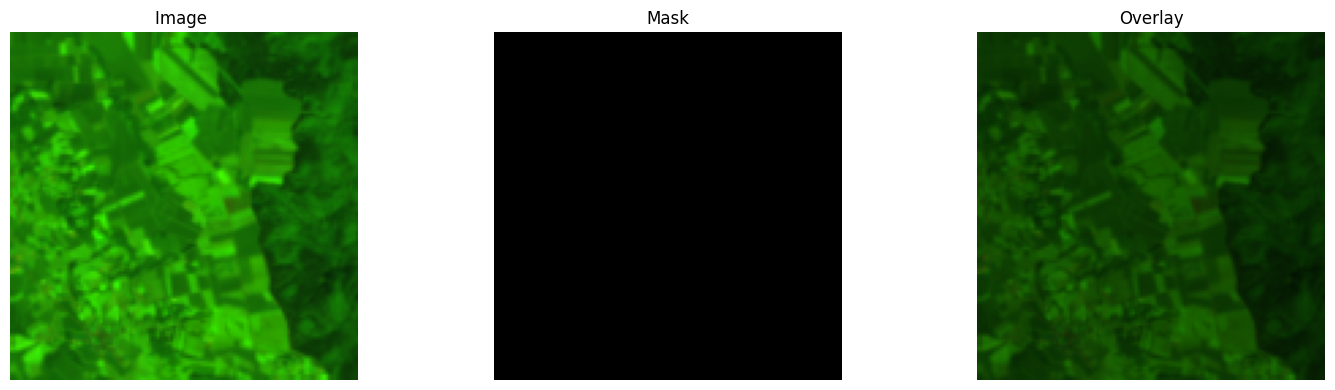

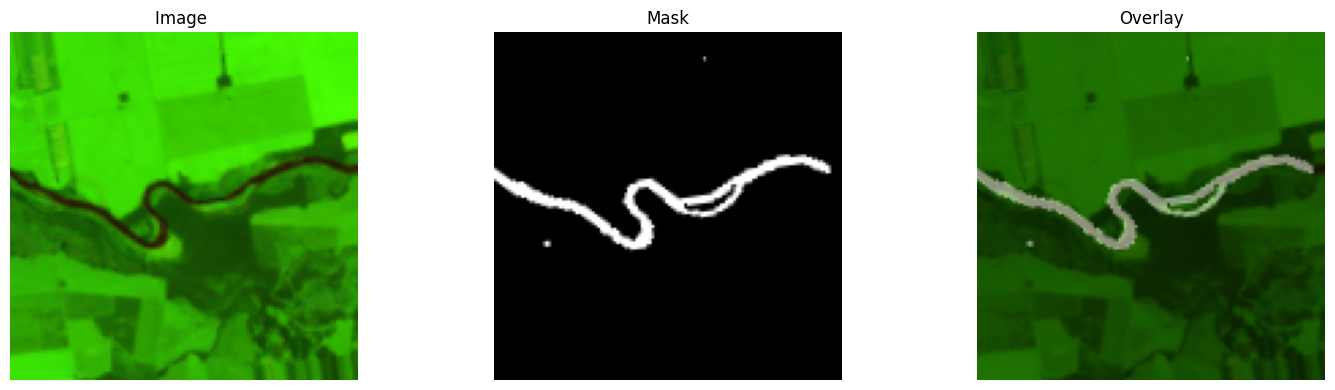

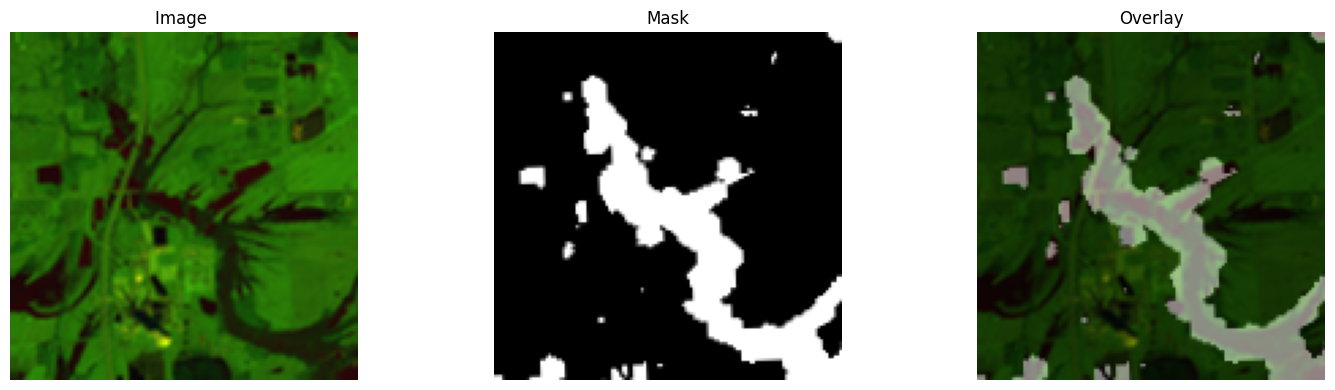

In [12]:
def visualize_generator_output(generator, num_samples=5, figsize=(15, 4)):
    """
    Visualize samples from the data generator.
    
    Parameters:
    - generator: generator yielding batches of (images, masks)
    - num_samples: int, number of samples to visualize
    - figsize: tuple, size of the figure for each sample
    """
    # Get a batch from the generator
    images, masks = next(generator)
    
    # Visualize up to num_samples or the batch size, whichever is smaller
    n = min(num_samples, len(images))
    
    for i in range(n):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
        
        # Display the image
        # Assuming the image has 12 channels
        rgb_image = images[i][:,:,]  
        rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())
        ax1.imshow(rgb_image)
        ax1.set_title("Image ")
        ax1.axis('off')
        
        # Display the mask
        ax2.imshow(masks[i].squeeze(), cmap='gray')
        ax2.set_title("Mask")
        ax2.axis('off')
        
        # Display the overlay
        ax3.imshow(rgb_image)
        ax3.imshow(masks[i].squeeze(), alpha=0.5, cmap='gray')
        ax3.set_title("Overlay")
        ax3.axis('off')
        
        plt.tight_layout()
        plt.show()
visualize_generator_output(train_gen, num_samples=5)


In [13]:
BACKBONE = 'mobilenet'
BATCH_SIZE = 8
CLASSES = ['1']
LR = 0.001

preprocess_input = sm.get_preprocessing(BACKBONE)

In [14]:


# define network parameters
n_classes = 1 
activation = 'sigmoid' 

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation,encoder_weights='imagenet')

/opt/conda/lib/python3.10/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [15]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(),sm.metrics.Recall()]

# compile keras model with defined optimozer, loss and metrics
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)

In [16]:
# Create a callback that saves the model's weights
checkpoint = ModelCheckpoint(
    filepath='unet_model_checkpoint.keras',  # File path where the model will be saved
    monitor='val_f1-score',  # Metric to monitor
    verbose=1,  # Verbosity mode, 1 will print messages when saving the model
    save_best_only=True,  # Save only the best model according to the monitored metric
    mode='max'  # Mode for the monitored metric, 'max' to save when it increases
)

In [17]:
#implement Early stopping

early_stopping = EarlyStopping(
    monitor='val_f1-score',
    patience=15,
    restore_best_weights=True,
    mode='max'
)

In [18]:
# trying different learning rates 

reduce_lr = ReduceLROnPlateau(
    monitor='val_f1-score',
    factor=0.1,
    patience=5,
    min_lr=0.0000000001
)

In [19]:
his=model.fit(train_gen, 
             epochs=19, 
             steps_per_epoch=len(train_images) // batch_size, 
             validation_data=val_gen,
             validation_steps=len(val_images) // batch_size,
             callbacks = [checkpoint, early_stopping, reduce_lr])



Epoch 1/19


I0000 00:00:1726025016.972398    7894 service.cc:145] XLA service 0x7901a0004fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726025016.972451    7894 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726025016.972455    7894 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/30 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - f1-score: 0.4481 - iou_score: 0.2916 - loss: 0.7462 - precision: 0.2812 - recall: 0.5488  

I0000 00:00:1726025035.382512    7894 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1-score: 0.6337 - iou_score: 0.4874 - loss: 0.5864 - precision: 0.4315 - recall: 0.6464
Epoch 1: val_f1-score improved from -inf to 0.11087, saving model to unet_model_checkpoint.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - f1-score: 0.6356 - iou_score: 0.4894 - loss: 0.5841 - precision: 0.4338 - recall: 0.6476 - val_f1-score: 0.1109 - val_iou_score: 0.0589 - val_loss: 1.9334 - val_precision: 0.4819 - val_recall: 0.0634 - learning_rate: 0.0010
Epoch 2/19
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - f1-score: 0.7911 - iou_score: 0.6683 - loss: 0.3543 - precision: 0.6992 - recall: 0.7310
Epoch 2: val_f1-score improved from 0.11087 to 0.35527, saving model to unet_model_checkpoint.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - f1-score: 0.7898 - iou_score: 0.6665 - loss: 0.3556 - precision: 0.6984 - recall: 0.7303 - val_f1-score: 0.3553 - val_iou_score: 0.2179 - val_loss: 6.2785 - val_precision: 0.2176 - val_recall: 0.9908 - learning_rate: 0.0010
Epo

In [20]:
# To evaluate on the test set
results = model.evaluate(test_gen, steps=len(test_images) // batch_size)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - f1-score: 0.8976 - iou_score: 0.8150 - loss: 0.1789 - precision: 0.9173 - recall: 0.8125


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


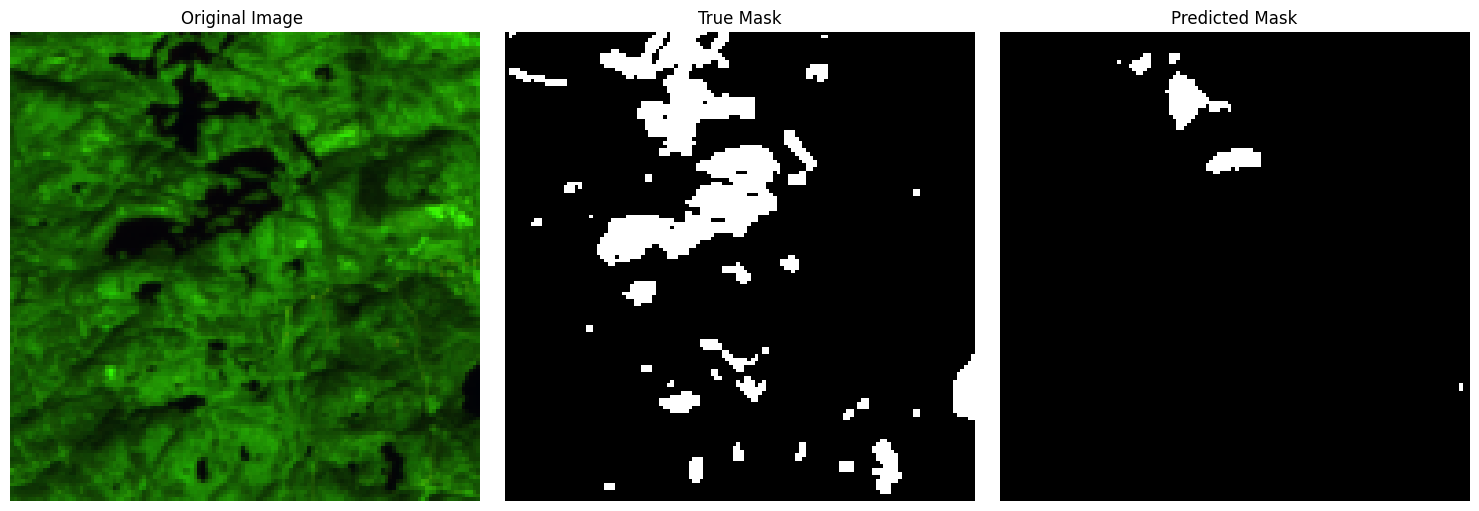

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


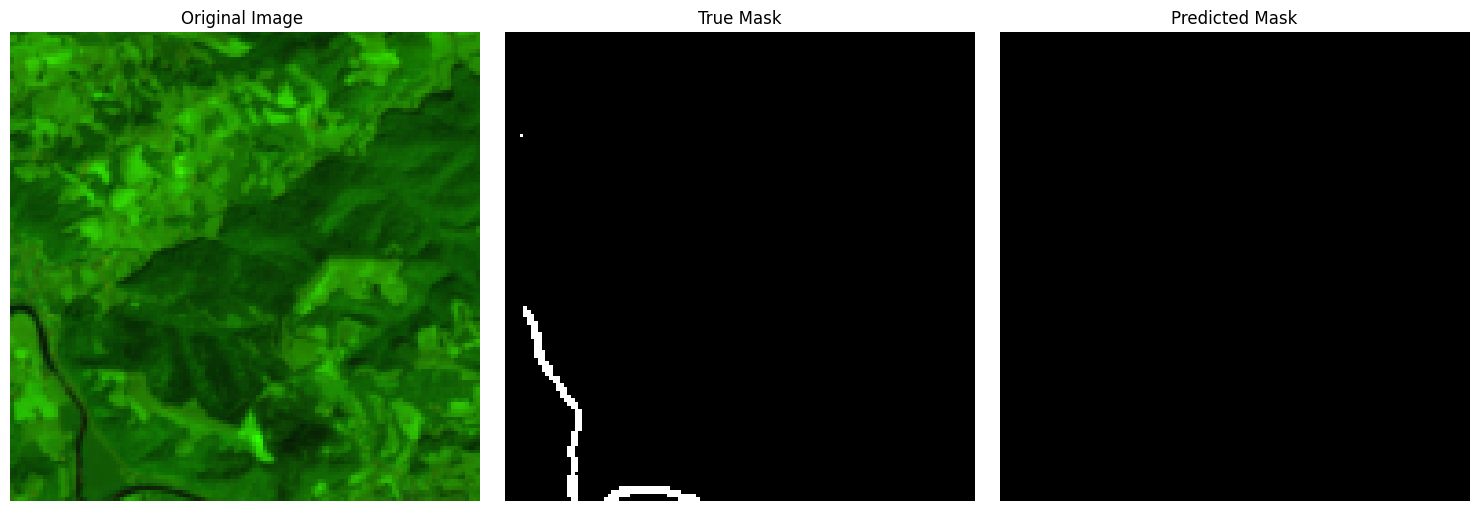

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


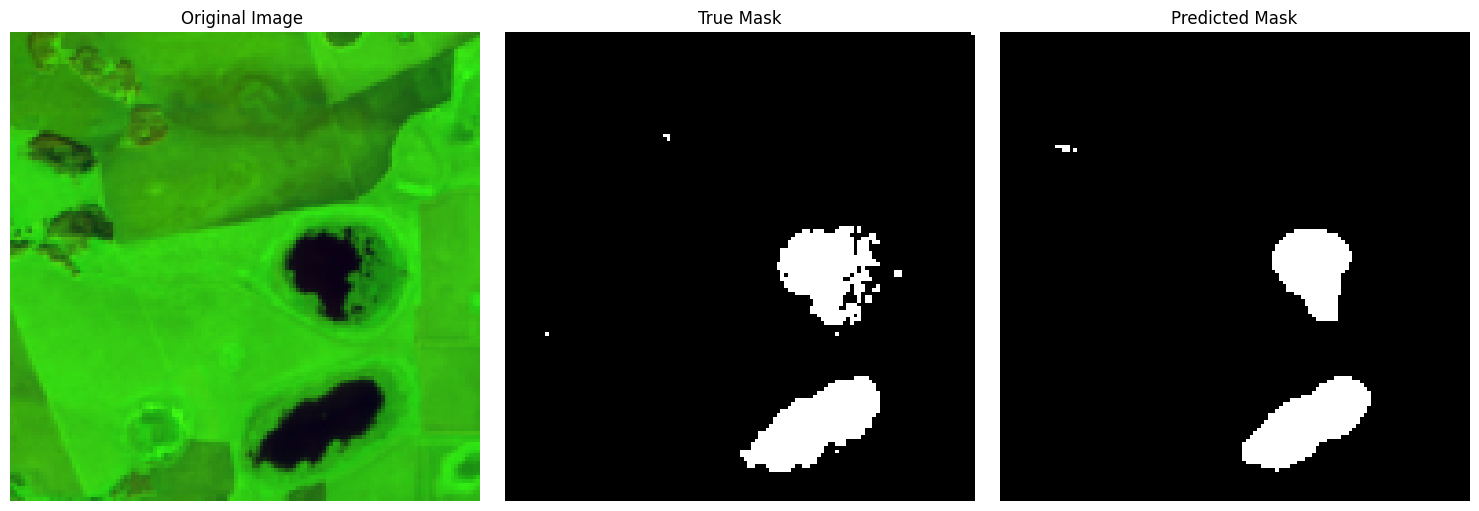

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


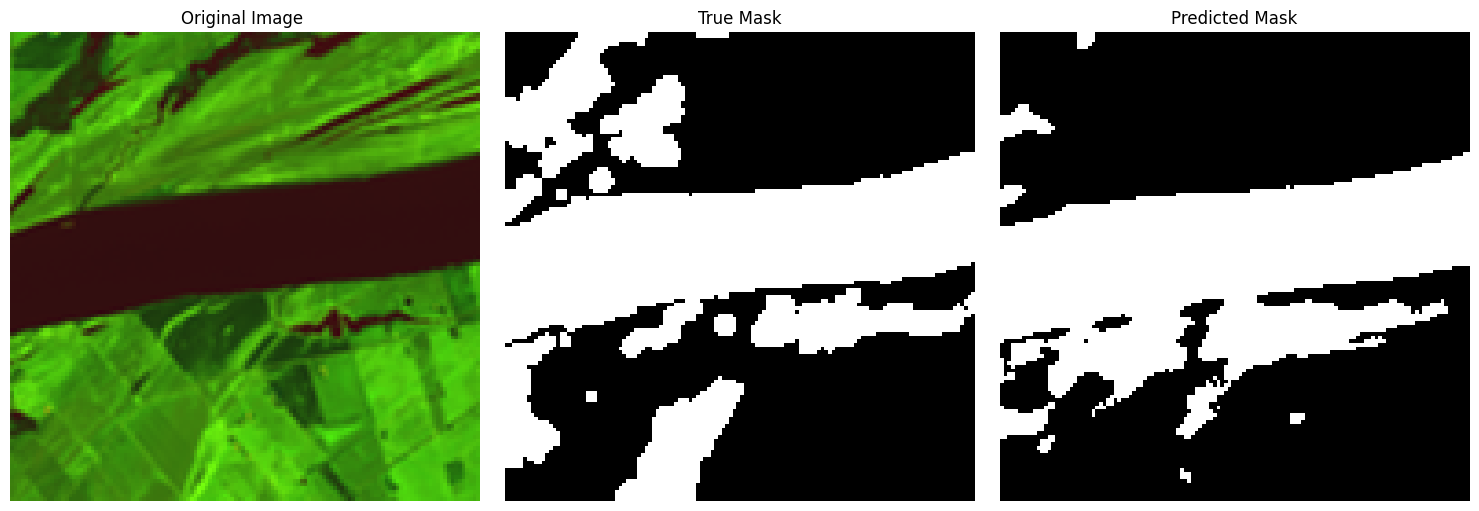

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


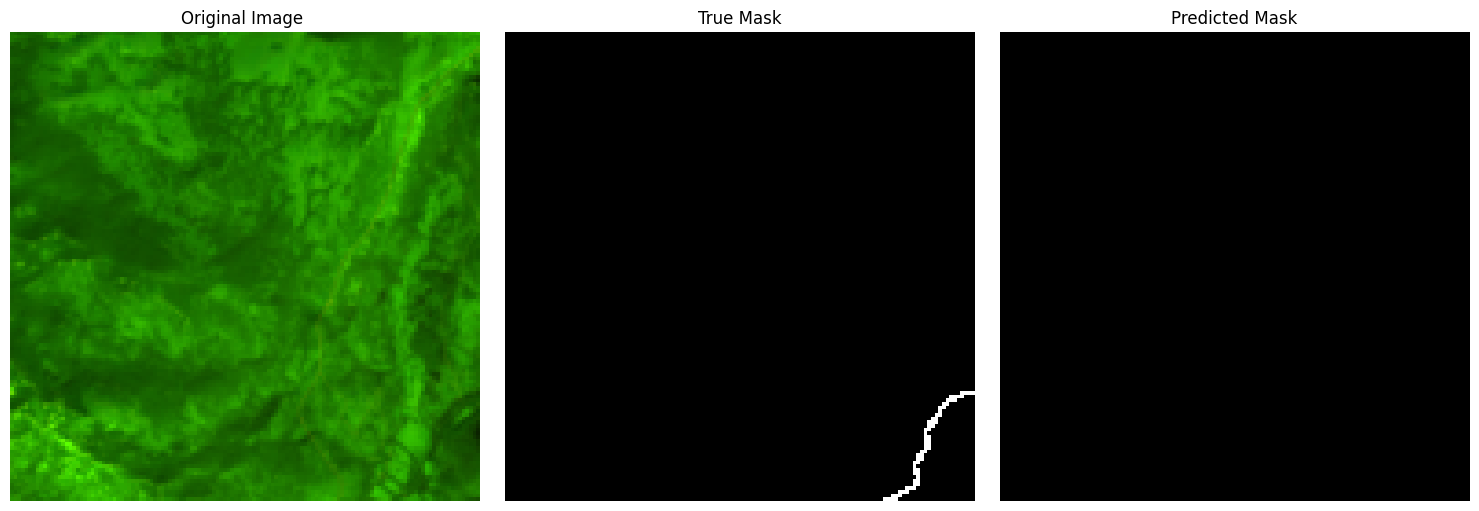

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


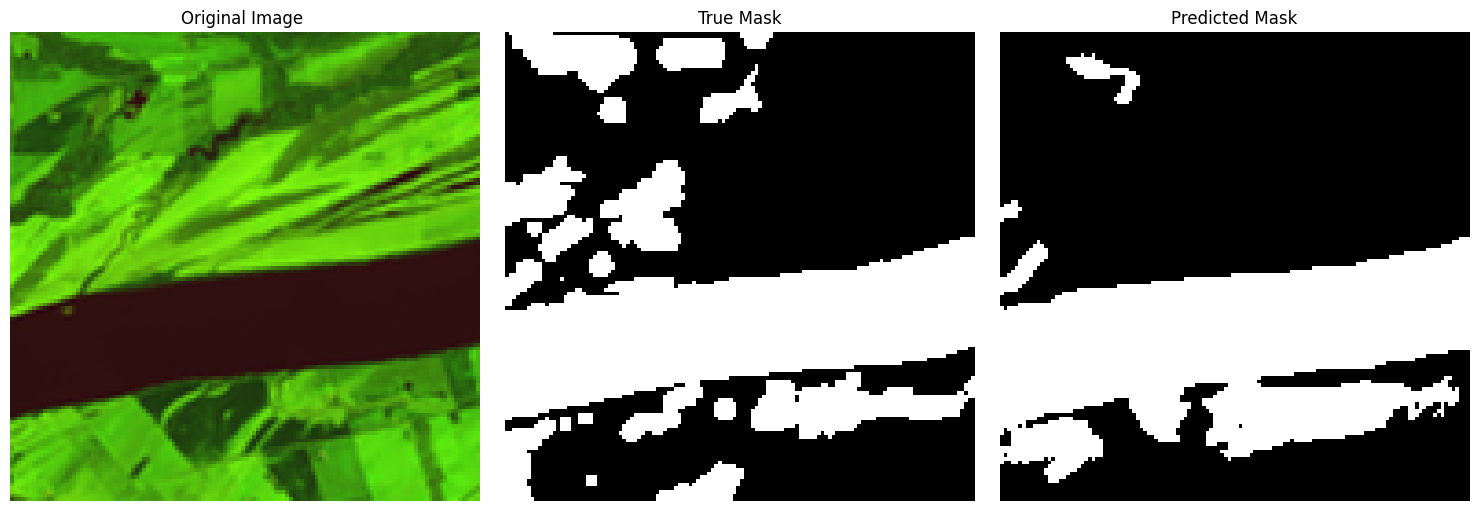

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


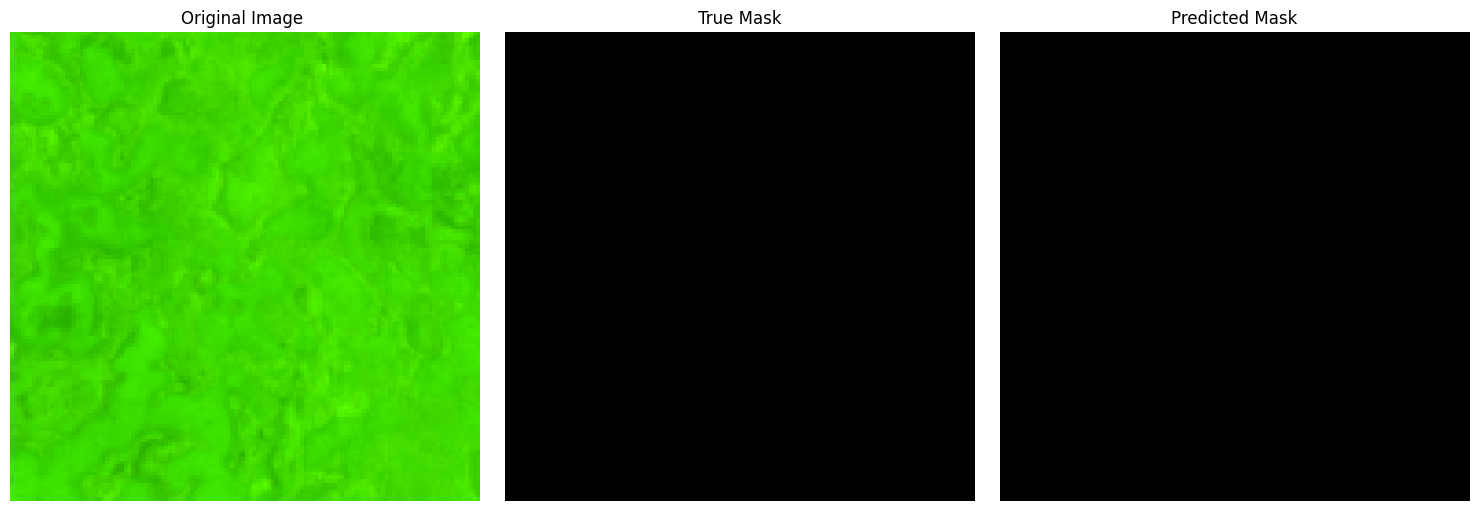

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


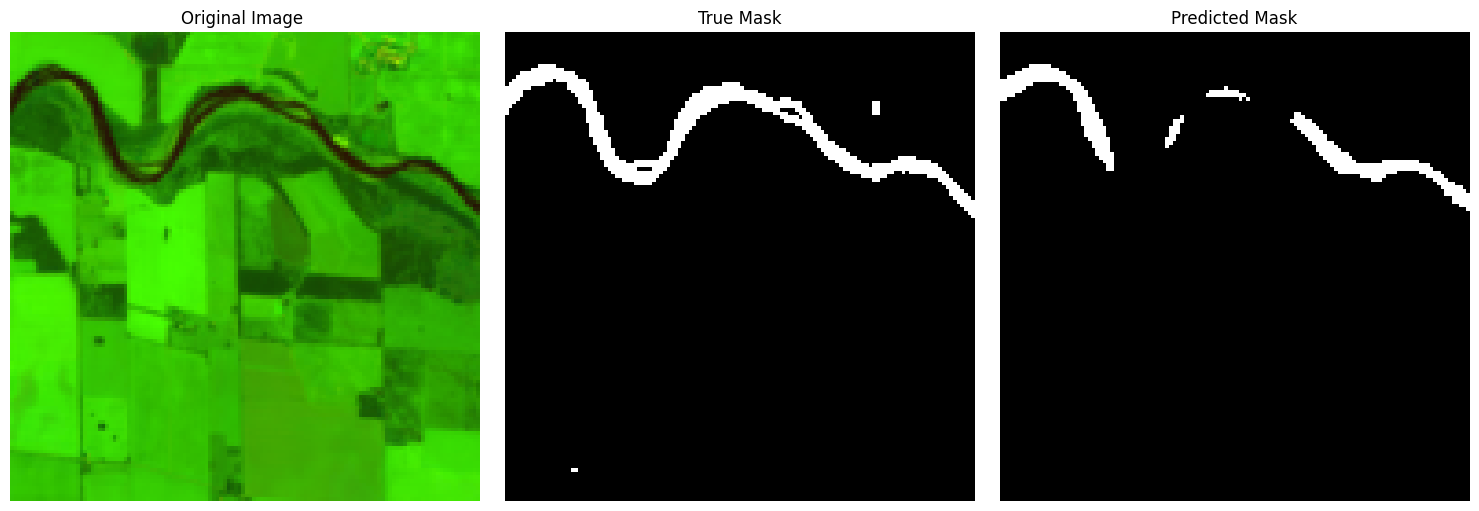

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


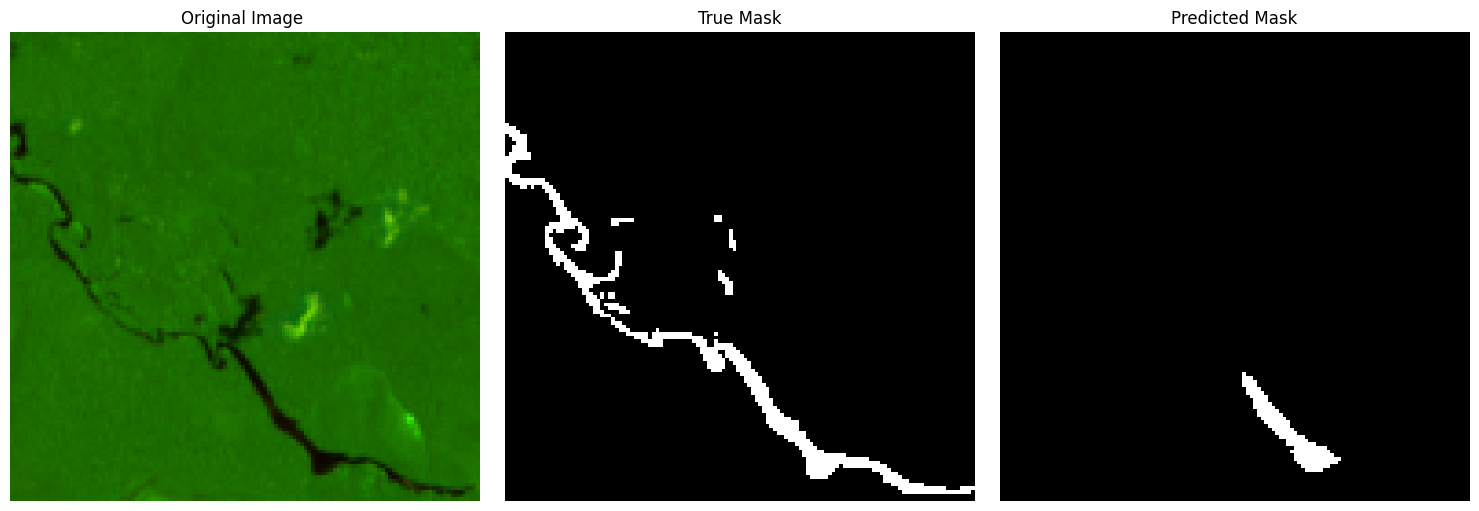

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


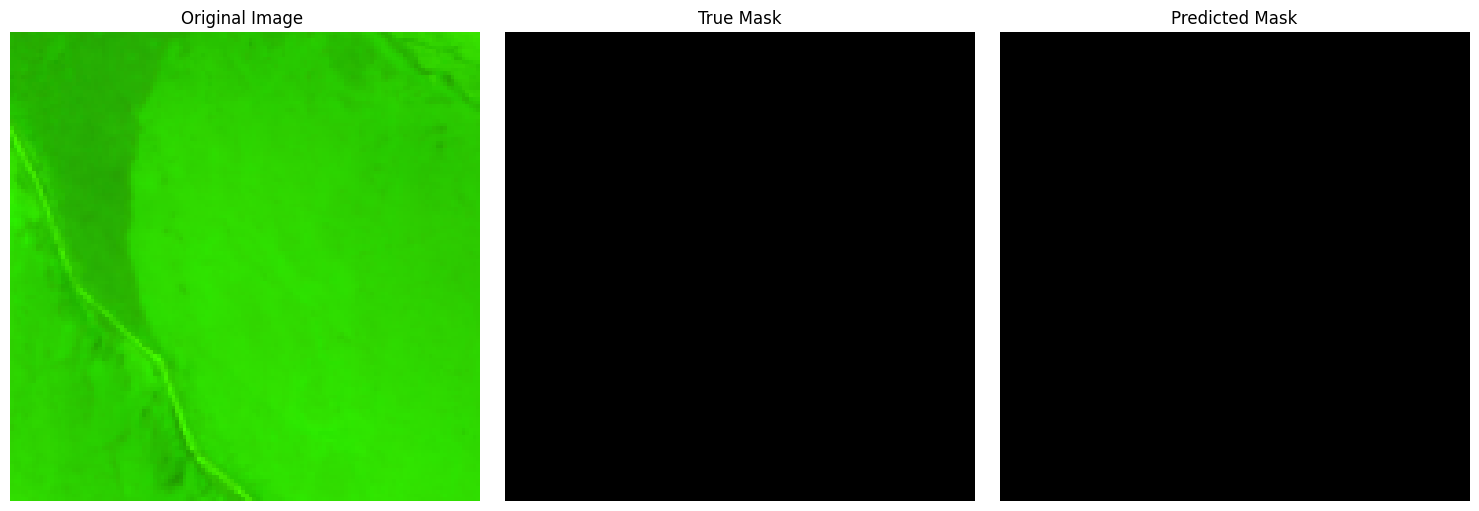

In [21]:
def plot_predictions(model, image_list, label_list, target_size, num_samples=10):
    """
    Function to plot original images, true masks, and predicted masks.
    
    Parameters:
    - model: Trained segmentation model
    - image_list: List of paths to original images
    - label_list: List of paths to true mask images
    - target_size: Tuple of target size for the images and masks
    - num_samples: Number of samples to plot
    """
    for i in range(num_samples):
        img_path = image_list[i]
        label_path = label_list[i]
        
        # Load and preprocess the image and mask
        img, true_mask = load_image(img_path, label_path, target_size)
        
        # Predict the mask
        pred_mask = model.predict(tf.expand_dims(img, axis=0))[0]
        
        
        # Convert to numpy and normalize for visualization
        img = img.numpy()
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        
        # Plot original RGB image
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title('Original Image ')
        plt.imshow(img)
        plt.axis('off')
        
        # Plot true mask
        plt.subplot(1, 3, 2)
        plt.title('True Mask')
        plt.imshow(tf.squeeze(true_mask), cmap='gray')
        plt.axis('off')
        
        # Plot predicted mask
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(tf.squeeze(pred_mask) > 0.5, cmap='gray')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
plot_predictions(model, image_list, label_list, target_size=(128, 128), num_samples=10)
